## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language models (for decoder and encoder)

* or just fine-tunning BART/ELECTRA/... ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip install subword-nmt
! pip install nltk
# ! pip install torchtext
! pip install torchtext==0.6

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.9/771.9 kB 5.0 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
deeppavlov 1.1.0 requires filelock<3.10.0,>=3.0.0, but you have filelock 3.12.0 which is incompatible.
deeppavlov 1.1.0 requires numpy<1.24, but you have numpy 1.24.2 which is incompatible.
deeppavlov 1.1.0 requires pandas<1.6.0,>=1.0.0, but you have pandas 2.0.1 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because nor

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
--2023-05-21 15:08:29--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  45.6MB/s    in 0.3s    

2023-05-21 15:08:30 (45.6 MB/s) - ‘data.txt’ saved [12905334/12905334]



Baseline solution BLEU score is quite low. Try to achieve at least __21__ BLEU on the test set. 
The checkpoints are:

* __21__ - minimal score to submit the homework, 30% of points

* __25__ - good score, 70% of points

* __27__ - excellent score, 100% of points

### Warning! The code below is deeeeeeeply deprecated and is is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface: 
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [5]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


In [6]:
import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator, TabularDataset

In [9]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

NVIDIA TITAN V
NVIDIA TITAN V
NVIDIA TITAN RTX
NVIDIA TITAN RTX


In [10]:
device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")
print("device:", device)

device: cuda:2


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [11]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [12]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [13]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [14]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [15]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [16]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9303
Unique tokens in target (en) vocabulary: 6737


Here are tokens from original (RU) corpus:

In [17]:
SRC.vocab.itos[::1000]

['<unk>',
 'люксах',
 'готовы',
 'купаться',
 'nest',
 'detroit',
 'moro',
 'утапао',
 'деталями',
 'стороны']

And from target (EN) corpus:

In [18]:
TRG.vocab.itos[::1000]

['<unk>', 'spot', 'classes', 'circle', 'mirage', 'smoked', 'magazine']

And here is example from train dataset:

In [19]:
print(vars(train_data.examples[9]))

{'trg': ['jacque', 'vacation', 'home', 'has', 'a', 'concierge', 'desk', 'that', 'can', 'assist', 'guests', 'with', 'requests', 'during', 'their', 'stay', '.'], 'src': ['сотрудники', 'стойки', 'регистрации', 'дома', 'отдыха', 'jacque', 'готовы', 'ответить', 'на', 'вопросы', 'гостей', 'и', 'выполнить', 'их', 'пожелания', '.']}


Let's check the length distributions:

Length distribution in Train data


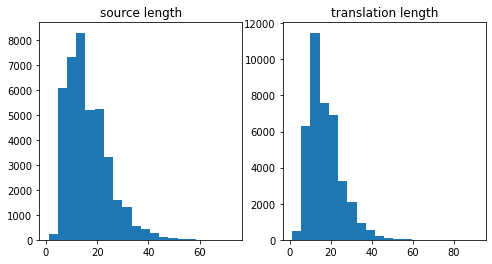

In [20]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


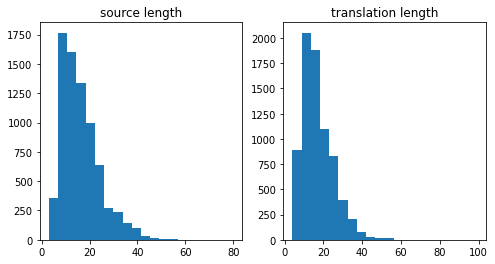

In [21]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [22]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [23]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 37x128 (GPU 2)]
	[.src]:[torch.cuda.LongTensor of size 38x128 (GPU 2)]
torch.Size([38, 128]) torch.Size([37, 128])


In [24]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [37]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [38]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9303, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6737, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6737, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [39]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,918,737 trainable parameters


In [40]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
lr_scheduler = StepLR(optimizer=optimizer, step_size=3, gamma=0.5)

In [41]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [42]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [43]:
def extract_mins_and_secs(elapsed_time):
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [44]:
def train_model(model, train_iterator, valid_iterator, optimizer, criterion,
                lr_scheduler, n_epochs, clip, model_name="model.pth"):
    
    train_history = []
    valid_history = []
    best_valid_loss = float('inf')

    total_time = 0

    for epoch in range(n_epochs):
        
        start_time = time.time()
        
        train_loss = train(model, train_iterator, optimizer, criterion, clip, train_history, valid_history)
        valid_loss = evaluate(model, valid_iterator, criterion)

        lr_scheduler.step(valid_loss)
        
        end_time = time.time()
        
        elapsed_time = end_time - start_time
        total_time += elapsed_time
        epoch_mins, epoch_secs = extract_mins_and_secs(elapsed_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_name)
        
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    total_mins, total_secs = extract_mins_and_secs(total_time)
    print(f'Total train time: {total_mins}m {total_secs}s')

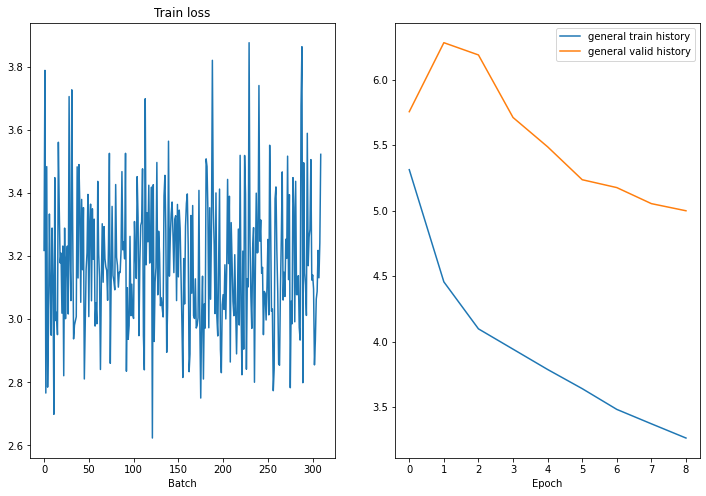

Epoch: 10 | Time: 1m 21s
	Train Loss: 3.174 | Train PPL:  23.898
	 Val. Loss: 4.927 |  Val. PPL: 137.988
Total train time: 13m 7s


In [45]:
train_model(model, train_iterator, valid_iterator, 
            optimizer, criterion, lr_scheduler, 
            n_epochs=10, clip=1, model_name="model.pt")

__Let's take a look at our network quality__:

In [48]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [49]:
batch = next(iter(test_iterator))

In [50]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: extras include ironing facilities .
Generated: a .

Original: the bathroom has a shower .
Generated: comprises a private bathroom with a shower .



In [51]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [52]:
import tqdm

In [76]:
def get_generated_texts(model, test_iterator):
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():

        for i, batch in tqdm.tqdm(enumerate(test_iterator)):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.argmax(dim=-1)
            
            original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

    return original_text, generated_text

In [54]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

11.12870708733177

The BLEU score for the basic model is much lower than required minimum.
So let's try some other models.

### Seq2Seq model with attention

In [69]:
imp.reload(my_network)
Encoder = my_network.Encoder
DecoderAttention = my_network.DecoderAttention
Seq2SeqAttention = my_network.Seq2SeqAttention

In [70]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec_attention = DecoderAttention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model_attention = Seq2SeqAttention(enc, dec_attention, device).to(device)

In [71]:
model_attention.apply(init_weights)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(9303, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): DecoderAttention(
    (embedding): Embedding(6737, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (attention): Attention(
      (linear_in): Linear(in_features=512, out_features=512, bias=False)
      (linear_out): Linear(in_features=1024, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (out): Linear(in_features=512, out_features=6737, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [72]:
optimizer_attention = optim.AdamW(model_attention.parameters())
criterion_attention = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
lr_scheduler_attention = ReduceLROnPlateau(optimizer=optimizer_attention, patience=2, factor=0.2)

In [120]:
print(f'The model has {count_parameters(model_attention):,} trainable parameters')

The model has 15,705,169 trainable parameters


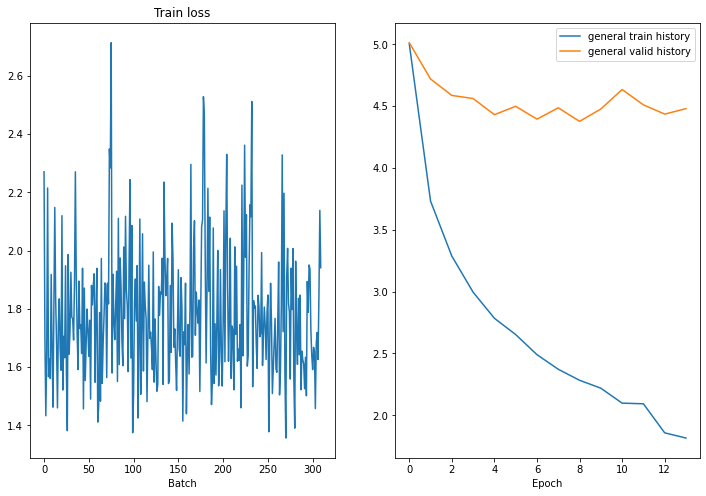

Epoch: 15 | Time: 1m 51s
	Train Loss: 1.780 | Train PPL:   5.932
	 Val. Loss: 4.517 |  Val. PPL:  91.556
Total train time: 23m 48s


In [73]:
train_model(model_attention, train_iterator, valid_iterator, 
            optimizer_attention, criterion_attention, lr_scheduler_attention, 
            n_epochs=15, clip=1, model_name="model_attention.pt")

In [77]:
orig_text_attention, gen_text_attention = get_generated_texts(model_attention, test_iterator)

59it [00:04, 13.78it/s]


In [78]:
corpus_bleu([[text] for text in orig_text_attention], gen_text_attention) * 100

31.40145788689665

In [79]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model_attention, TRG.vocab)

Original: guests can visit spa at the , . the spa features 12 treatment rooms including a couple ’ s suite and vip suite , locker facilities with showers , sauna , herbal steam and whirlpool , a fitness center and full service salon . the luxurious spa offers signature treatments inspired by traditional chinese ( ), - edge technology and boutique lines .
Generated: the at the spa spa , the spa , spa , , spa , , spa , , a spa , , a spa , , a spa , , a spa , , , , , , , , - - .

Original: porta romana apartments is a collection of independent properties all located in milan , close to porta romana area and just 15 minutes away by foot from the duomo . the area of porta romana is full of all of restaurants , clubs , theatres and is well - served by public means of transport , with and porta romana yellow metro line stops in the vicinity , the tram lines 15 and 24 e the bus line stop .
Generated: apartamentos is located in different locations in milan , close to the roman locations and the

This model has shown great BLEU score result. Compared to the basic model it trains much longer: ~24mins vs ~13mins. Yet the improvement is also significant.
Now let's try Transformer model implemented based on `nn.Transformer`.

### Transformer

In [80]:
imp.reload(my_network)
Seq2SeqTransformer = my_network.Seq2SeqTransformer

In [96]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
NHEAD = 2
ENC_LAYERS = 2
DEC_LAYERS = 2
EMB_DIM = 512
DROPOUT = 0.2

model_transformer = Seq2SeqTransformer(INPUT_DIM, OUTPUT_DIM, EMB_DIM,
                                       NHEAD, ENC_LAYERS, DEC_LAYERS, device=device).to(device)
optimizer_transformer = optim.AdamW(model_transformer.parameters())
criterion_transformer = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
lr_scheduler_transformer = ReduceLROnPlateau(optimizer=optimizer_transformer, patience=2, factor=0.2)

In [97]:
print(f'The model has {count_parameters(model_transformer):,} trainable parameters')

The model has 26,383,442 trainable parameters


In [98]:
def init_weights_transformer(m):
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

In [99]:
model_transformer.apply(init_weights_transformer)

Seq2SeqTransformer(
  (enc_emb): Embedding(9303, 512)
  (dec_emb): Embedding(6737, 512)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_model): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_af

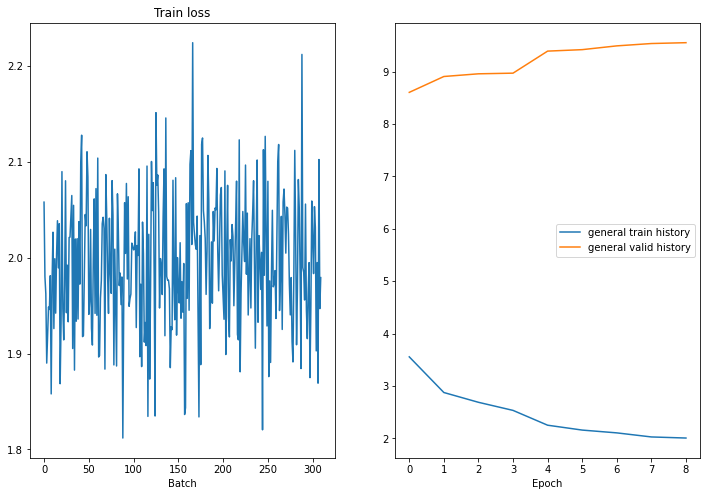

Epoch: 10 | Time: 0m 57s
	Train Loss: 1.994 | Train PPL:   7.345
	 Val. Loss: 9.713 |  Val. PPL: 16525.420
Total train time: 9m 27s


In [100]:
train_model(model_transformer, train_iterator, valid_iterator, 
            optimizer_transformer, criterion_transformer, 
            lr_scheduler_transformer, n_epochs=10, clip=1, 
            model_name="model_transformer.pt")

In [101]:
orig_text_transformer, gen_text_transformer = get_generated_texts(model_transformer, test_iterator)

59it [00:13,  4.36it/s]


In [102]:
corpus_bleu([[text] for text in orig_text_transformer], gen_text_transformer) * 100

7.826161042800403

In [103]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model_transformer, TRG.vocab)

Original: guests can visit spa at the , . the spa features 12 treatment rooms including a couple ’ s suite and vip suite , locker facilities with showers , sauna , herbal steam and whirlpool , a fitness center and full service salon . the luxurious spa offers signature treatments inspired by traditional chinese ( ), - edge technology and boutique lines .
Generated: ’ s restaurant offers a bar , a variety of cocktails , and international cuisine , and a range of cocktails .

Original: porta romana apartments is a collection of independent properties all located in milan , close to porta romana area and just 15 minutes away by foot from the duomo . the area of porta romana is full of all of restaurants , clubs , theatres and is well - served by public means of transport , with and porta romana yellow metro line stops in the vicinity , the tram lines 15 and 24 e the bus line stop .
Generated: is a 5 - minute drive from and a 30 - minute drive from .



The implemeted version of transformer performed worse than the basic model, no matter how I tuned parameters of the model. It might be due to lack of train as transformers require a lot of data to train and fine-tune in the canonical architecture. And also it might need some regularization hints.

### Transformer for Machine Translation

Let's try to implement another version of transformer which is more suitable for machine translation task.

In [104]:
imp.reload(my_network)
LanguageTransformer = my_network.LanguageTransformer

In [110]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
NHEAD = 2
ENC_LAYERS = 2
DEC_LAYERS = 2
EMB_DIM = 512
DROPOUT = 0.2

language_transformer = LanguageTransformer(INPUT_DIM, OUTPUT_DIM, EMB_DIM,
                                        NHEAD, ENC_LAYERS, DEC_LAYERS, device=device).to(device)
optimizer_language_transformer = optim.AdamW(language_transformer.parameters())
criterion_language_transformer = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
lr_scheduler_language_transformer = ReduceLROnPlateau(optimizer=optimizer_language_transformer, patience=2, factor=0.2)


In [111]:
print(f'The model has {count_parameters(language_transformer):,} trainable parameters')

The model has 26,383,442 trainable parameters


In [112]:
def train_lang_transformer(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output.view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

    return epoch_loss / len(iterator)


def evaluate_transformer(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


def train_transformer(model, train_iterator, valid_iterator, optimizer, criterion,
                lr_scheduler, n_epochs, clip, model_name="model.pth"):
    
    train_history = []
    valid_history = []
    best_valid_loss = float('inf')
    total_time = 0

    for epoch in range(n_epochs):
        
        start_time = time.time()
        
        train_loss = train_lang_transformer(model, train_iterator, optimizer, criterion, clip, train_history, valid_history)
        valid_loss = evaluate_transformer(model, valid_iterator, criterion)

        lr_scheduler.step(valid_loss)
        
        end_time = time.time()
        
        elapsed_time = end_time - start_time
        total_time += elapsed_time
        epoch_mins, epoch_secs = extract_mins_and_secs(elapsed_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_name)
        
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    total_mins, total_secs = extract_mins_and_secs(total_time)
    print(f'Total train time: {total_mins}m {total_secs}s')

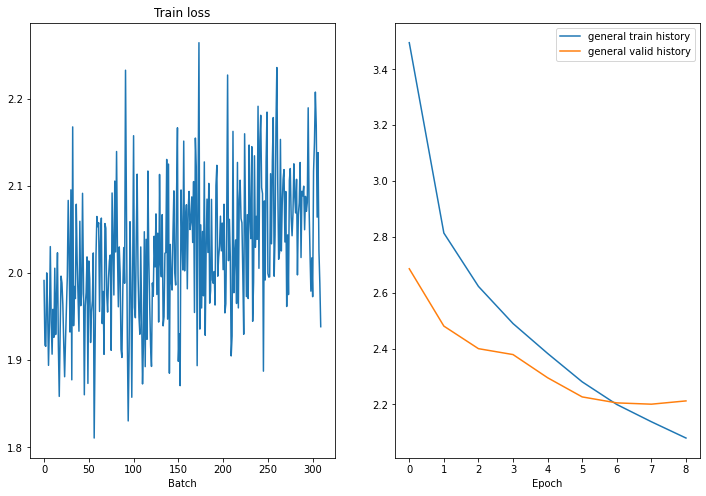

Epoch: 10 | Time: 0m 54s
	Train Loss: 2.023 | Train PPL:   7.561
	 Val. Loss: 2.187 |  Val. PPL:   8.905
Total train time: 8m 35s


In [114]:
train_transformer(language_transformer, train_iterator, valid_iterator, 
                  optimizer_language_transformer, criterion_language_transformer, 
                  lr_scheduler_language_transformer, n_epochs=10, clip=1, 
                  model_name="model_transformer.pt")

In [115]:
def get_generated_texts_from_transformer(model, test_iterator):
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():

        for i, batch in tqdm.tqdm(enumerate(test_iterator)):

            src = batch.src
            trg = batch.trg

            output = model(src, trg) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.argmax(dim=-1)
            
            original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

    return original_text, generated_text

In [116]:
orig_text_transformer, gen_text_transformer = get_generated_texts_from_transformer(language_transformer, test_iterator)

59it [00:01, 35.80it/s]


In [117]:
corpus_bleu([[text] for text in orig_text_transformer], gen_text_transformer) * 100

19.532888624611115

In [118]:
def generate_translation_transformer(src, trg, model, TRG_vocab):
    model.eval()

    output = model(src, trg) #turn off teacher forcing
    output = output.argmax(dim=-1).cpu().numpy()

    original = get_text(list(trg[:,0].cpu().numpy()), TRG_vocab)
    generated = get_text(list(output[1:, 0]), TRG_vocab)
    
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

In [119]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation_transformer(src, trg, language_transformer, TRG.vocab)

Original: guests can visit spa at the , . the spa features 12 treatment rooms including a couple ’ s suite and vip suite , locker facilities with showers , sauna , herbal steam and whirlpool , a fitness center and full service salon . the luxurious spa offers signature treatments inspired by traditional chinese ( ), - edge technology and boutique lines .
Generated: can enjoy the and the which

Original: porta romana apartments is a collection of independent properties all located in milan , close to porta romana area and just 15 minutes away by foot from the duomo . the area of porta romana is full of all of restaurants , clubs , theatres and is well - served by public means of transport , with and porta romana yellow metro line stops in the vicinity , the tram lines 15 and 24 e the bus line stop .
Generated: is is is located 10 of independent apartment , inclusive in the , just to the , , a - ’ from the . the .



As we can see the result of this transformer model is much better than the previous one. Although it could not achieve the minimal required BLEU score of 21, it was close to it and training was the fastest among reviewed models.

### Conclusion

|               | Basic Seq2Seq | Seq2Seq + Attention | Transformer | Language Transformer |
|---------------|---------------|---------------------|-------------|----------------------|
| BLEU score    | 11.1          | 31.4                | 7.8         | 19.5                 |
| Training time | 13m 7s        | 23m 48s             | 9m 27s      | 8m 35s               |
| #Params (M)   | 14.9          | 15.7                | 26.4        | 26.4                 |

- `Seq2Seq(LSTM-LSTM) + Attention` model showed the best BLEU score of 31.4, which is an excellent result. But it requires the most time for training;
- The second best BLEU score of 19.5 was achieved by `Language Transformer` model which is a little lower than minimal required 21 in task yet it is much better than baseline 11.1. And this model is the fastest to train;
- Transformer models have ~70% more params than networks.